# **Product Recognition of Books**

# Authors 
ID: 0001187926  Name: Cono Cirone         Email: cono.cirone@studio.unibo.it \
ID: 0001169321  Name: Jacopo Dardini      Email: jacopo.dardini@studio.unibo.it \
ID: 0001189948  Name: Giulio Petrozziello Email: giulio.petrozziello@studio.unibo.it

# Introduction

We present a system for detecting multiple instances of books in images of bookshelves. 
The algorithm takes as input the model image of a book and the target image of the scene:
if the sought item is found in the scene, the resulting output consists of the target image with additional bounding boxes, which are described by coordinates and area, locating the detected instances.

# Setup

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

# Detection

The detection is mainly carried out by the function `multi_instance_detection`, which relies on helper functions `compute_homography`, `project_to_scene`, `is_degenerate` to complete the task.

### `compute_homography`

It takes as input `kp_model` and `kp_scene`, the keypoints of the model and scene respectively, and `goods`, which contains the indexes of `kp_model` (i.e. `queryIdx`) and `kp_scene` (i.e. `trainIdx`) that match well enough under the criterion proposed by D. Lowe (see `multi_instance_detection`)

The function computes an optimal limited affine transformation with 4 degrees of freedom from the matched keypoints of the model image `src_pts` to the corresponding `dst_pts` of the scene using `cv2.estimateAffinePartial2D`, which relies on the RANSAC algorithm.

The resulting output is the matrix `affine`, which represents the estimated transformation and consists of a scaled roto-translation defined as follows
$$
\begin{bmatrix} \cos(\theta) \cdot s & -\sin(\theta) \cdot s & t_x \\ \sin(\theta) \cdot s & \cos(\theta) \cdot s & t_y \end{bmatrix}
$$
where $\theta$ is the roation angle, $s$ the scaling factor and $t_x$, $t_y$ the translations in $x$, $y$ axes respectively.

The choice of estimating this transformation relies on our observations on the nature of the dataset: 
in every scene the books appear directly in front of the image plane of the camera, meaning that geometrical distortions caused by the view point of the observer were minimal.
This allowed to simplifiy the complexity of the estimation of the transform from a perspective to a limited affine one.

In [21]:
def compute_homography(kp_model, kp_scene, goods):
    # Get coordinates of matched keypoints in model_gray (src) and scene_gray (dst) images
    src_pts = np.float32([kp_model[m.queryIdx].pt for m in goods])
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in goods])

    # Estimate affine transformation (rotation, scale, translation)
    affine, _ = cv2.estimateAffinePartial2D(src_pts, 
                                         dst_pts, 
                                         method=cv2.RANSAC,
                                         ransacReprojThreshold=5
                                         )
    return affine

### `project_to_scene`

It takes as input
- `H`: the previously estimated affine transformation matrix
- `option`: the geometrical type of the objects involved in the projection: they are either points (`Option.CORNERS`) or rectangles (`Option.MASK`).
- `h`, `w`: height and width in pixels of the model image
- `model_gray`: the gray-scale model image used only when option == `Option.MASK`

This function performs a transformation encoded by `H` of some object in the model's reference system to some object in the scene's one.
The type of the objects depends on the value of the `option`, which can be either:
- `Option.CORNERS`: project the corners of the model image onto the scene and return the resulting points. 
    The result represents the corners of the bounding box of the detected book in the scene.
- `Option.MASK`: project a white mask with the same resolution of `model_gray` onto the scene. 
    The result is a black and white image with the same resolution of the scene image where the pixels with intensity 255 are part of the bounding box of the book in the scene.

In [22]:
class Option(Enum):
    CORNERS = 1
    MASK = 2

def project_to_scene(H, option, h, w, model_gray=None):
    if option == Option.CORNERS:
        src_corners = np.float32([[0,0],        # top-right
                                  [0,h-1],      # bottom-right
                                  [w-1,h-1],    # bottom-left 
                                  [w-1,0]]      # top-left
                                ).reshape(-1, 1, 2)
        dst_corners = cv2.transform(src_corners, H).astype(int)
        result = dst_corners 
    elif option == Option.MASK:
        # Model BW-mask to be projected on the scene
        model_mask = np.full_like(model_gray, 255, dtype=np.uint8)
        warped_mask = cv2.warpAffine(model_mask, H, (w, h))
        result = warped_mask
    else:
        raise Exception()
    return result

### `is_degenerate`
It takes as input the matrix `H`, the previously estimated affine transformation matrix
$$
\begin{bmatrix} \cos(\theta) \cdot s & -\sin(\theta) \cdot s & t_x \\ \sin(\theta) \cdot s & \cos(\theta) \cdot s & t_y \end{bmatrix}
$$
and computes
$$
\det(\begin{bmatrix} \cos(\theta) \cdot s & -\sin(\theta) \cdot s \\ \sin(\theta) \cdot s & \cos(\theta) \cdot s \end{bmatrix}) = s^2
$$
i.e. the determinant of the linear part (rotation + scaling) of the affine transformation, which represent the area scaling factor.
For our purpose this factor must be big enough such that the area of the projected book is reasonably sized.


In [23]:
def is_degenerate(H):
    return np.linalg.det(H[:, :2]) < .1

### `multi_instance_detection`
It takes as input:
- `model`: the RGB model image
- `scene`: the RGB scene image that may contain the sought book
- `scene_with_box`: the RGB scene image where bounding boxes may be added
- `color`: color of the next bounding box to add to `scene_with_box` upon detection

It returns as output:
- `rects_coords`: a list of corners' coordinates in the scene denoting the position of the bounding boxes in the scene image
- `scene_with_box`: the previous input parameter that may contain additional bounding boxes

The estimated bounding boxes correspond to the rectangular regions of the scene image where the book of the model image has been detected. 

#### **Execution flow**
This function implements the core operations of the detection pipeline.
<!-- After converting the images' intensities from RGB to grayscale, keypoint detection is performed using the SIFT descriptor. -->
The main execution flow of the algorithm is defined as follows:
1. Convert both `scene` and `model` to their grayscale equivalents `scene_gray` and `model_gray`.
2. Detect keypoints `kp_model` and compute the corresponding descriptors `des_model` of `model_gray` using SIFT
3. Loop through the following steps\
    3.1. Detect keypoints `kp_scene` and compute the corresponding descriptors `des_scene` of `scene_gray` using SIFT\
    3.2. Find matches between `des_model` and `des_scene` using Brute Force matching\
    3.3. Filter in the best matches `goods` using the criterion proposed by D. Lowe\
    3.4. If this is the first iteration, store the number of best matches in `first_count`\
    3.5 Check if `len(goods) > threshold` and `first_count/len(goods) < 7.5`

If the condition in 3.5 is not satisfied exit the loop, otherwise perform the following:

3.5.1. Compute the projection of the matched keypoints of the model to the scene by calling `compute_homography(...)`\
3.5.2. Check if the resulting projection is degenerate by calling `is_degenerate(...)`: if the result is positive exit the loop\
3.5.3. Compute the projection of the model image corners `proj_corners` on the scene and the corresponding mask `proj_mask` by calling `project_to_scene(...)`\
3.5.4. Store `proj_corners` in `rects_coords` and draw the corresponding bounding box on `scene_with_box`.\
3.5.5. Obscure the region of the bounding box in `scene_gray` by using the `proj_mask` and go to step 4.

Finally return `rects_coords` and `scene_with_box`

#### **Implementation rationale**
**Detection criterion**\
We observed that as the bounding boxes of the books are cut out from `scene_gray` (see step 3.5.5) the number of good matches decreases with each successive iteration in the loop. Since it wasn't possible to set a unique `threshold` (see step 3.5) that would allow a correct detection over all instances, we relied on the following intuition: if the current number of good matches is much lower than the number of good matches recorded in the first detection, than the detection process shall terminate. 
This idea is encoded in the additional constraint in step 3.5 `first_count/len(goods) < 7.5`, where `goods` is the list of the current good matches obtained in step 3.3. The chosen augmented criterion was parametrized empirically.

\
**Matching algorithm**\
Instead of choosing the FLANN algorithm for the matching process, we preferred Brute Force matching.
Although this choice implies a higher computational cost, the benefit is the consistency of results, as the Brute Force algorithm is deterministic.

\
**SIFT parameter tuning**\
The parameters passed to the descriptor are set differently from the combination proposed by D. Lowe in order to directly address the nature of the dataset:
- `nOctaveLayers`: the number of layers within the octave. 
    It has been increased from 3 to 13 in order to improve scale sampling and allow for finer keypoint detection.
- `sigma`: the sigma of the Gaussian applied to the input image at the octave #0.
    It has been decreased from 1.6 to 1.4, which decreases smoothing and allows to detect more features.
- `contrastThreshold`: the contrast threshold used to filter out weak features in low-contrast regions.
    The value was decreased from 0.03 to 0.009 in order to increase the number of detected keypoints

Even though the implementation proposed by D. Lowe is computationally more efficient, the chosen combination of parameters drastically increases the detection performance:
- The number of good matches between the model and the scene containing instances the model's book is much higher than in the case where the scene doesn't contain any instance: this behavior renders the distinction between correct detections and false detections much easier, rendering the pipeline more robust.
- The localization of the bounding box is more precise, as more keypoints allow for a better and more robust estimation.

Finally decreasing the parameters `sigma` and `contrastThreshold` in theory could lead to false detection due to noise. Nevertheless considering the overall combination of dataset features and detection criterion parameters, this problem didn't arise.

In [24]:
def multi_instance_detection(model, scene, scene_with_box, color):
    # List of rectangle corners' coordinates
    rects_coords=[]
    # Threshold on the number of good enough matches
    threshold = 44
    # Parameters for homographies
    model_height, model_width = model.shape[:2]
    scene_height, scene_width = scene.shape[:2]
    # Detection flag
    model_detected = True
    # SIFT descriptor
    sift = cv2.SIFT_create(nOctaveLayers=13, sigma=1.4, contrastThreshold=.009)
    # Matching method
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # Number of good matches on the first iteration
    first_count = 0

    # RGB -> GRAY
    model_gray, scene_gray = (
        cv2.cvtColor(model, cv2.COLOR_RGB2GRAY),
        cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    )

    # SIFT model_detected on the 
    kp_model, des_model = sift.detectAndCompute(model_gray, None)

    while model_detected:

        # SIFT model_detected on the scene
        kp_scene, des_scene = sift.detectAndCompute(scene_gray, None)

        # Brute force apprach (deterministic)
        matches = bf.knnMatch(des_model, des_scene, k=2)

        # Good matches filtering using D. Lowe's criterion
        goods = np.array([f for f,s in matches if f.distance < 0.7*s.distance])

        # Store the number of good matches on the first iteration
        if first_count == 0:
            first_count = len(goods)

        # Detection criterion
        model_detected = len(goods) > threshold and first_count/len(goods) < 7.5

        if model_detected:
            
            # Compute homography as an affine transformation
            H = compute_homography(kp_model, kp_scene, goods)

            # Check if the transformation is degenerate
            if is_degenerate(H):
                return rects_coords

            # Project model corners and model mask to the scene
            proj_corners = project_to_scene(
                H, Option.CORNERS, model_height, model_width
            )
            proj_mask = project_to_scene(
                H, Option.MASK,    scene_height, scene_width, model_gray
            )

            # Store rectangle coordinates
            proj_corners_int = proj_corners.reshape(4,2).astype(int)
            rects_coords.append(
                {"top_left":        tuple(proj_corners_int[0].tolist()),
                 "top_right":       tuple(proj_corners_int[3].tolist()),
                 "bottom_left":     tuple(proj_corners_int[1].tolist()),
                 "bottom_right":    tuple(proj_corners_int[2].tolist()),
                 "area": int(
                        (np.linalg.norm(proj_corners[0][0]-proj_corners[3][0]))*
                        (np.linalg.norm(proj_corners[1][0]-proj_corners[2][0]))
                    )
                }
            )

            # Draw projected bounding box on scene_with_box
            cv2.polylines(
                scene_with_box, 
                [proj_corners], 
                isClosed=True, 
                color=color, 
                thickness=2
            )

            # Remove detected region from the scene
            scene_gray[proj_mask == 255] = 0
    
    return rects_coords

# Main Loop

The following code executes the detection pipeline for every combination of models and scenes.
If, and only if, any model appears in the current scene, the resulting bounding boxes' informations are shown togheter with the bounding boxes drawn on the scene.

The print-out of the bounding boxes information is to be read after this convention:
- `top_left|top_right|bottom_left|bottom_right: (x, y)`: the pixel coordinates of the specified corner of the model image as projected on the scene. `x` and `y` are the horizontal and vertical coordinates in the scene's reference system respectively. 
- `area:AREApx`: the area in pixels of the bounding box on the scene.

Based on the results all instances are detected correctly across all scenes.

Scene 1
Book 18 - 2 instance(s) found:
  Instance 1 {top_left: (441, 42), top_right: (490, 42), bottom_left: (441, 520), bottom_right: (490, 520), area: 2401px}
  Instance 2 {top_left: (488, 38), top_right: (537, 38), bottom_left: (481, 514), bottom_right: (530, 514), area: 2401px}


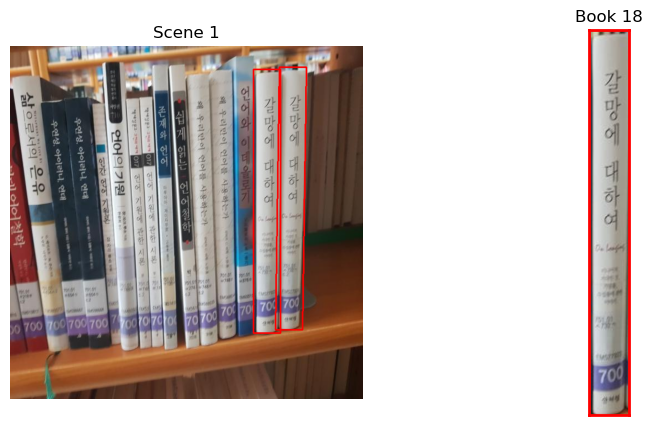

Scene 2
Book 17 - 1 instance(s) found:
  Instance 1 {top_left: (283, 25), top_right: (318, 25), bottom_left: (283, 503), bottom_right: (318, 503), area: 1225px}


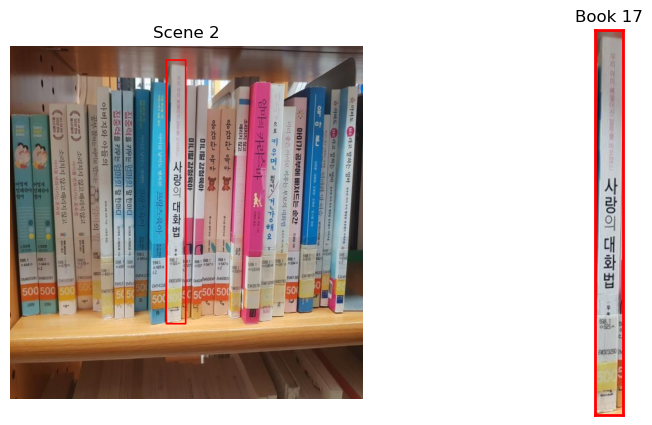

Scene 3
Book 16 - 2 instance(s) found:
  Instance 1 {top_left: (377, 209), top_right: (425, 209), bottom_left: (377, 542), bottom_right: (425, 542), area: 2304px}
  Instance 2 {top_left: (425, 209), top_right: (474, 210), bottom_left: (417, 548), bottom_right: (466, 549), area: 2401px}


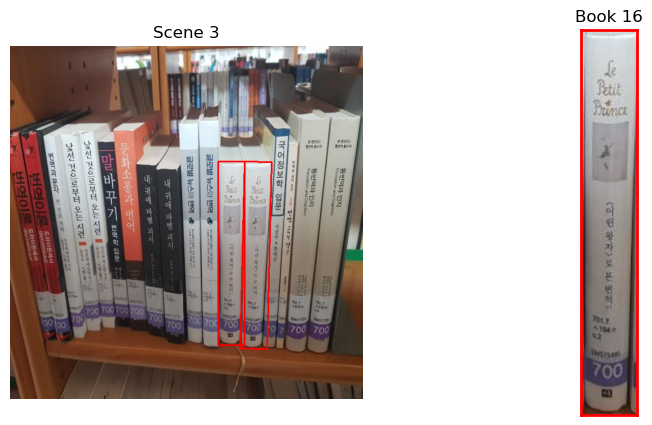

Scene 4
Book 14 - 2 instance(s) found:
  Instance 1 {top_left: (92, 1), top_right: (135, 1), bottom_left: (92, 617), bottom_right: (135, 617), area: 1849px}
  Instance 2 {top_left: (55, -2), top_right: (98, -3), bottom_left: (59, 619), bottom_right: (102, 619), area: 1849px}
Book 15 - 2 instance(s) found:
  Instance 1 {top_left: (226, 48), top_right: (267, 48), bottom_left: (226, 608), bottom_right: (267, 608), area: 1681px}
  Instance 2 {top_left: (192, 45), top_right: (233, 45), bottom_left: (197, 609), bottom_right: (238, 609), area: 1681px}


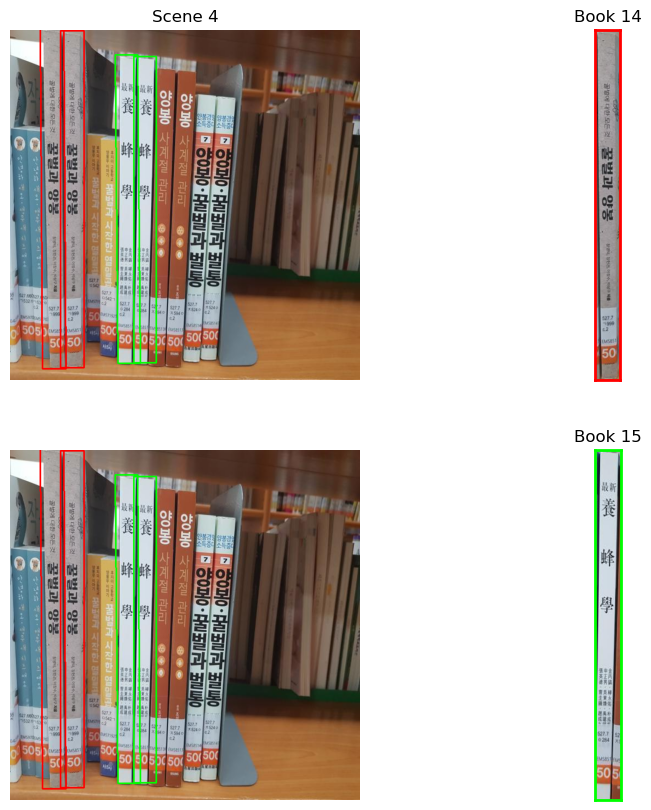

Scene 5
Book 13 - 1 instance(s) found:
  Instance 1 {top_left: (102, 69), top_right: (145, 69), bottom_left: (102, 572), bottom_right: (145, 572), area: 1849px}


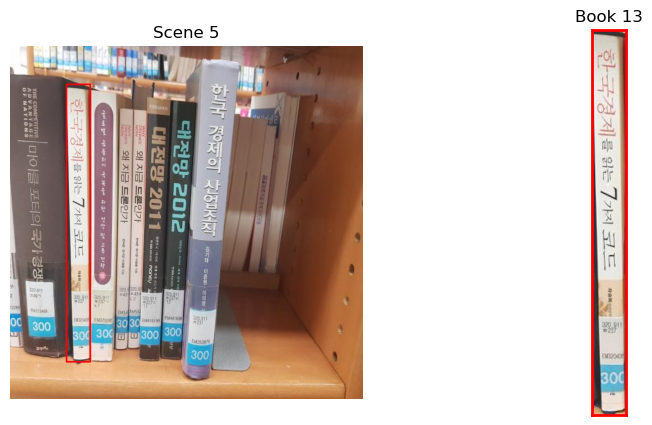

Scene 6
Book 21 - 1 instance(s) found:
  Instance 1 {top_left: (217, 73), top_right: (270, 73), bottom_left: (217, 563), bottom_right: (270, 563), area: 2809px}


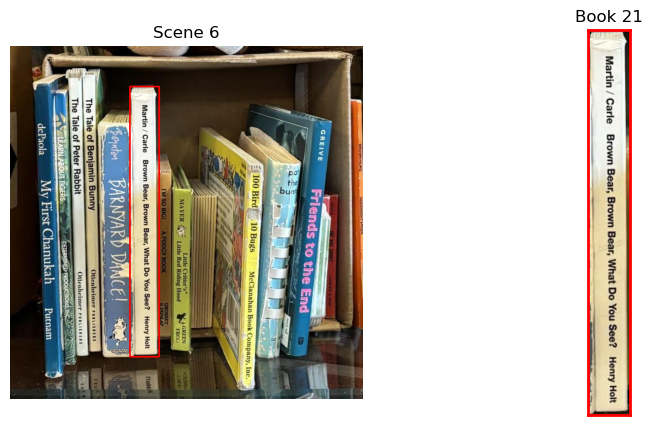

Scene 7
Book 20 - 2 instance(s) found:
  Instance 1 {top_left: (236, 173), top_right: (289, 173), bottom_left: (236, 555), bottom_right: (289, 555), area: 2809px}
  Instance 2 {top_left: (279, 171), top_right: (334, 171), bottom_left: (276, 562), bottom_right: (330, 562), area: 2970px}


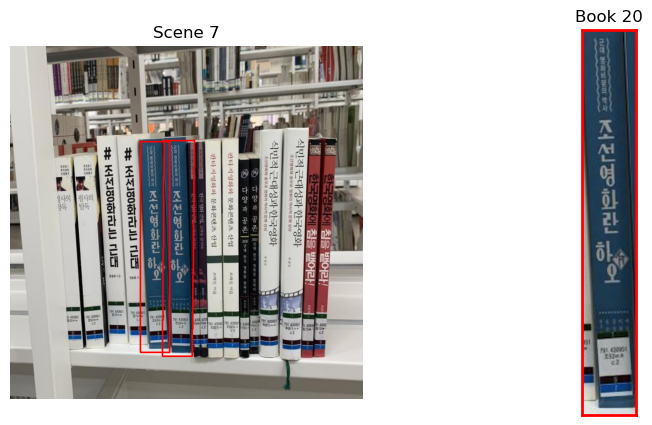

Scene 9
Book 19 - 4 instance(s) found:
  Instance 1 {top_left: (437, 328), top_right: (438, 355), bottom_left: (137, 339), bottom_right: (138, 366), area: 730px}
  Instance 2 {top_left: (437, 303), top_right: (438, 331), bottom_left: (136, 311), bottom_right: (137, 339), area: 785px}
  Instance 3 {top_left: (441, 382), top_right: (442, 409), bottom_left: (140, 392), bottom_right: (141, 419), area: 730px}
  Instance 4 {top_left: (439, 356), top_right: (440, 384), bottom_left: (137, 365), bottom_right: (138, 393), area: 785px}


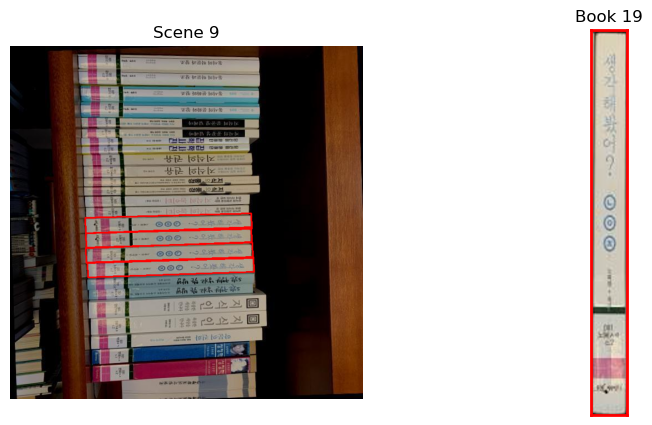

Scene 10
Book 19 - 4 instance(s) found:
  Instance 1 {top_left: (332, 203), top_right: (359, 203), bottom_left: (332, 503), bottom_right: (359, 503), area: 729px}
  Instance 2 {top_left: (307, 202), top_right: (335, 202), bottom_left: (304, 504), bottom_right: (332, 504), area: 784px}
  Instance 3 {top_left: (359, 202), top_right: (387, 202), bottom_left: (359, 504), bottom_right: (387, 504), area: 784px}
  Instance 4 {top_left: (385, 201), top_right: (413, 201), bottom_left: (385, 503), bottom_right: (413, 503), area: 784px}


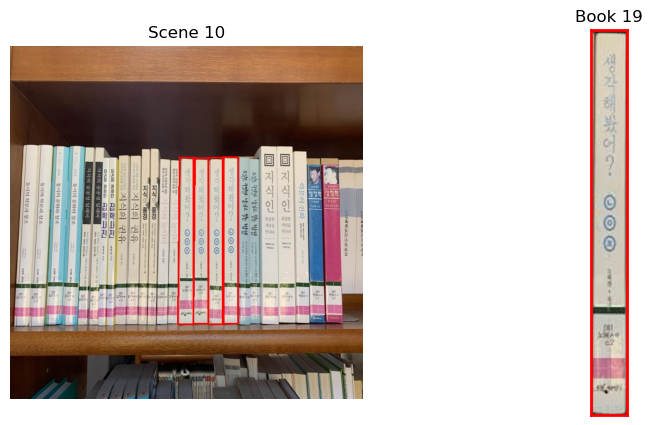

Scene 15
Book 11 - 2 instance(s) found:
  Instance 1 {top_left: (257, 187), top_right: (298, 187), bottom_left: (251, 534), bottom_right: (292, 535), area: 1681px}
  Instance 2 {top_left: (218, 184), top_right: (260, 185), bottom_left: (210, 537), bottom_right: (252, 538), area: 1765px}
Book 12 - 3 instance(s) found:
  Instance 1 {top_left: (500, 214), top_right: (529, 215), bottom_left: (494, 527), bottom_right: (523, 527), area: 841px}
  Instance 2 {top_left: (474, 212), top_right: (503, 213), bottom_left: (469, 527), bottom_right: (499, 528), area: 871px}
  Instance 3 {top_left: (525, 215), top_right: (554, 215), bottom_left: (518, 526), bottom_right: (547, 526), area: 841px}


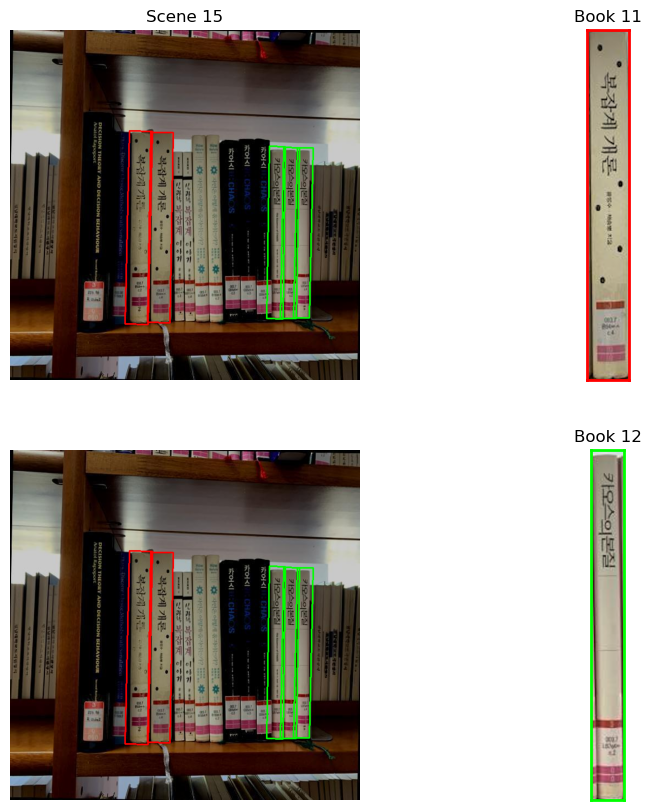

Scene 16
Book 11 - 2 instance(s) found:
  Instance 1 {top_left: (257, 187), top_right: (298, 187), bottom_left: (251, 534), bottom_right: (292, 535), area: 1681px}
  Instance 2 {top_left: (220, 187), top_right: (259, 188), bottom_left: (211, 521), bottom_right: (251, 522), area: 1561px}
Book 12 - 3 instance(s) found:
  Instance 1 {top_left: (500, 214), top_right: (529, 215), bottom_left: (494, 527), bottom_right: (523, 527), area: 841px}
  Instance 2 {top_left: (525, 215), top_right: (553, 215), bottom_left: (519, 525), bottom_right: (548, 526), area: 812px}
  Instance 3 {top_left: (474, 212), top_right: (503, 213), bottom_left: (469, 527), bottom_right: (499, 528), area: 871px}


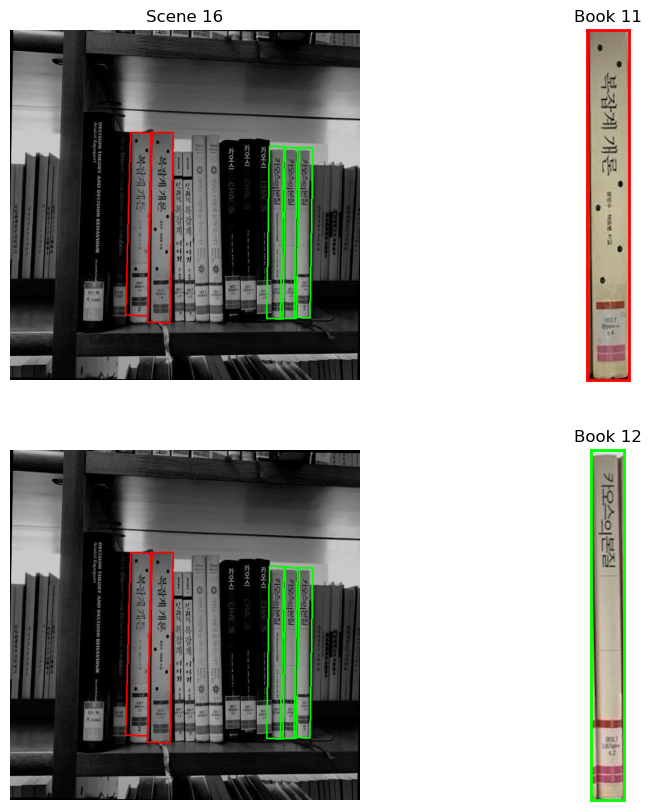

Scene 17
Book 11 - 2 instance(s) found:
  Instance 1 {top_left: (254, 187), top_right: (295, 187), bottom_left: (254, 535), bottom_right: (295, 535), area: 1681px}
  Instance 2 {top_left: (216, 185), top_right: (257, 185), bottom_left: (212, 538), bottom_right: (254, 538), area: 1722px}
Book 12 - 3 instance(s) found:
  Instance 1 {top_left: (497, 211), top_right: (526, 211), bottom_left: (497, 523), bottom_right: (526, 523), area: 841px}
  Instance 2 {top_left: (522, 211), top_right: (551, 211), bottom_left: (521, 522), bottom_right: (550, 522), area: 841px}
  Instance 3 {top_left: (471, 209), top_right: (501, 209), bottom_left: (472, 524), bottom_right: (501, 524), area: 870px}


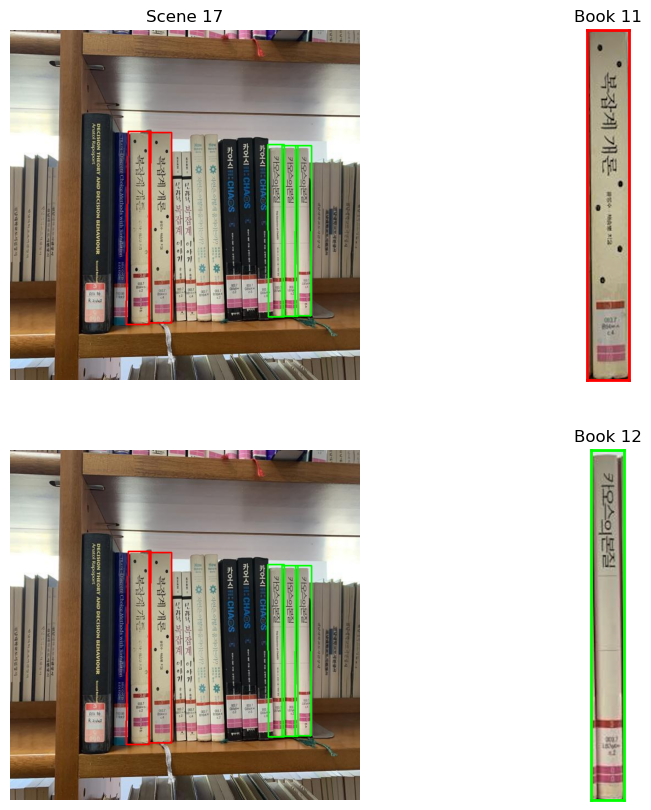

Scene 18
Book 8 - 3 instance(s) found:
  Instance 1 {top_left: (291, 131), top_right: (318, 131), bottom_left: (291, 586), bottom_right: (318, 586), area: 729px}
  Instance 2 {top_left: (314, 133), top_right: (341, 133), bottom_left: (317, 587), bottom_right: (344, 587), area: 729px}
  Instance 3 {top_left: (266, 128), top_right: (293, 128), bottom_left: (264, 585), bottom_right: (291, 585), area: 729px}
Book 9 - 3 instance(s) found:
  Instance 1 {top_left: (315, 130), top_right: (342, 130), bottom_left: (315, 586), bottom_right: (342, 586), area: 729px}
  Instance 2 {top_left: (291, 128), top_right: (318, 128), bottom_left: (289, 585), bottom_right: (316, 585), area: 729px}
  Instance 3 {top_left: (267, 125), top_right: (294, 126), bottom_left: (262, 583), bottom_right: (289, 584), area: 730px}
Book 10 - 3 instance(s) found:
  Instance 1 {top_left: (108, 38), top_right: (135, 38), bottom_left: (108, 584), bottom_right: (135, 584), area: 729px}
  Instance 2 {top_left: (138, 43), top_ri

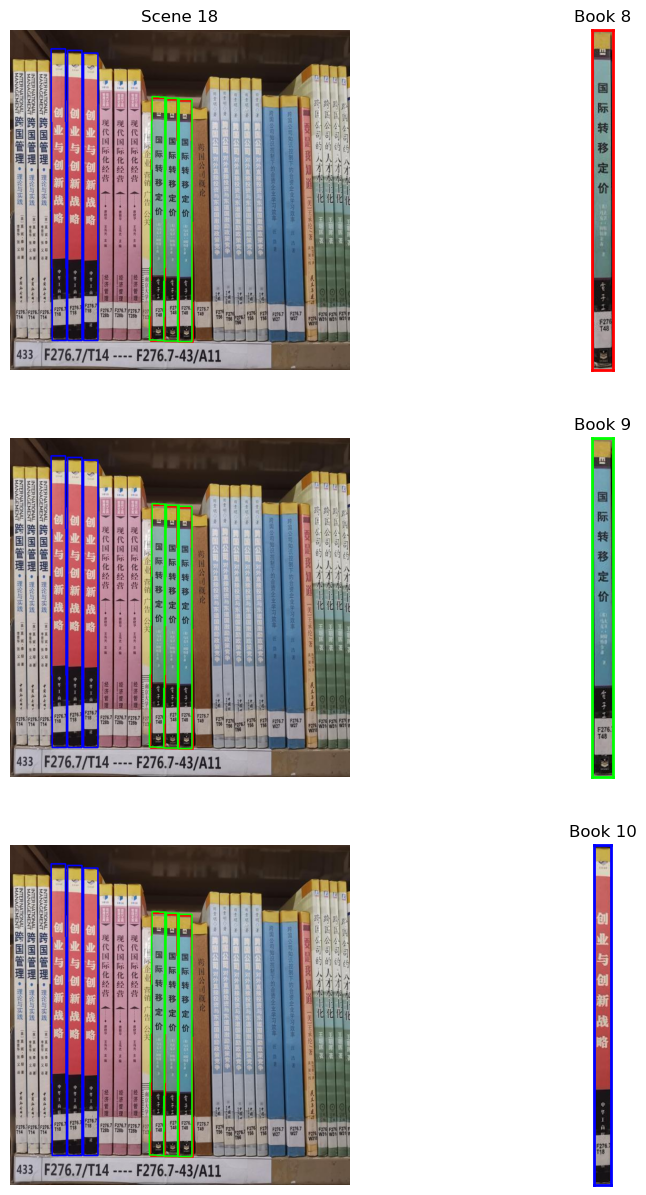

Scene 19
Book 6 - 3 instance(s) found:
  Instance 1 {top_left: (385, 32), top_right: (410, 32), bottom_left: (385, 579), bottom_right: (411, 579), area: 650px}
  Instance 2 {top_left: (438, 25), top_right: (464, 25), bottom_left: (438, 578), bottom_right: (464, 578), area: 676px}
  Instance 3 {top_left: (411, 29), top_right: (437, 29), bottom_left: (409, 577), bottom_right: (435, 577), area: 676px}
Book 7 - 2 instance(s) found:
  Instance 1 {top_left: (497, 40), top_right: (533, 40), bottom_left: (497, 587), bottom_right: (533, 587), area: 1296px}
  Instance 2 {top_left: (458, 43), top_right: (494, 43), bottom_left: (459, 583), bottom_right: (495, 582), area: 1296px}


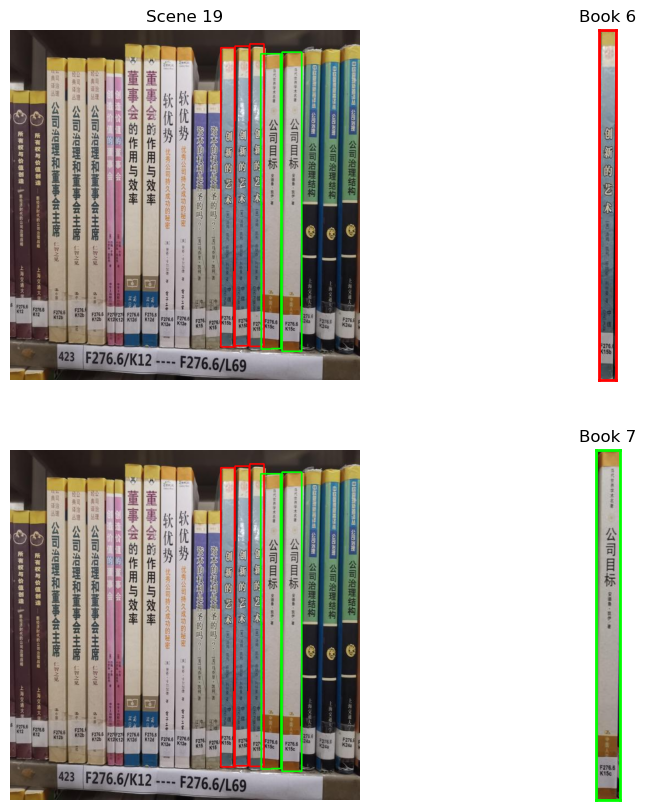

Scene 23
Book 5 - 1 instance(s) found:
  Instance 1 {top_left: (342, 149), top_right: (391, 149), bottom_left: (342, 571), bottom_right: (391, 571), area: 2401px}


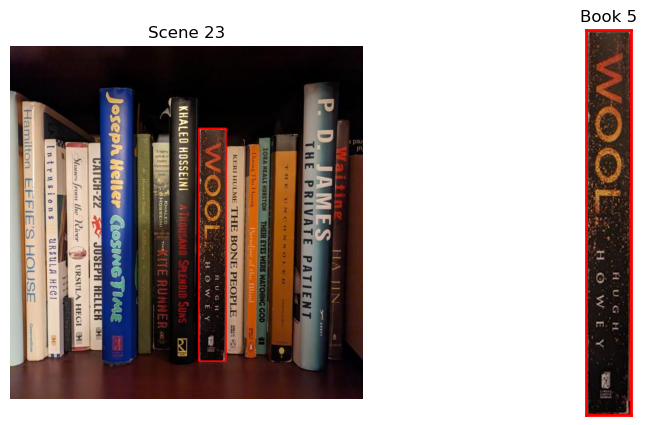

Scene 26
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (210, 180), top_right: (243, 180), bottom_left: (210, 567), bottom_right: (243, 567), area: 1089px}
  Instance 2 {top_left: (169, 182), top_right: (203, 181), bottom_left: (175, 571), bottom_right: (209, 570), area: 1157px}
Book 4 - 1 instance(s) found:
  Instance 1 {top_left: (248, 183), top_right: (432, 183), bottom_left: (248, 526), bottom_right: (432, 526), area: 33856px}


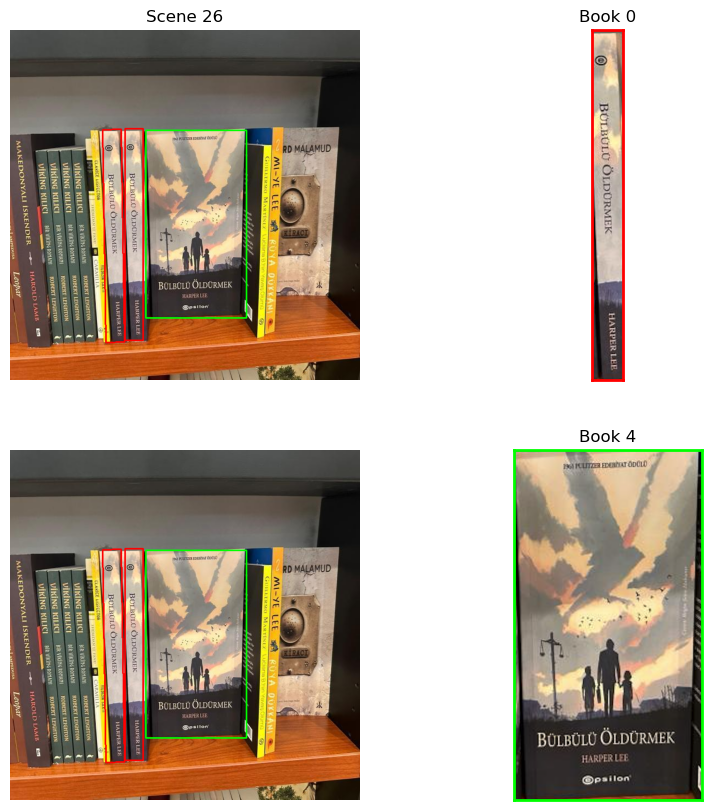

Scene 27
Book 2 - 2 instance(s) found:
  Instance 1 {top_left: (257, 146), top_right: (302, 146), bottom_left: (257, 563), bottom_right: (302, 563), area: 2025px}
  Instance 2 {top_left: (316, 118), top_right: (366, 120), bottom_left: (300, 584), bottom_right: (349, 586), area: 2454px}
Book 3 - 2 instance(s) found:
  Instance 1 {top_left: (420, 145), top_right: (456, 147), bottom_left: (407, 568), bottom_right: (443, 569), area: 1298px}
  Instance 2 {top_left: (377, 132), top_right: (416, 133), bottom_left: (361, 580), bottom_right: (399, 582), area: 1484px}


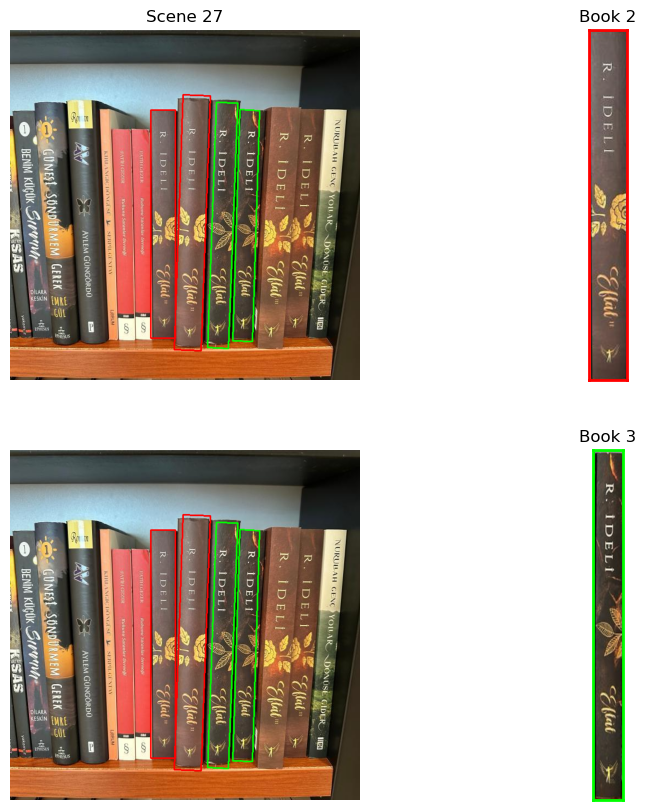

Scene 28
Book 1 - 2 instance(s) found:
  Instance 1 {top_left: (207, 247), top_right: (235, 248), bottom_left: (206, 554), bottom_right: (235, 554), area: 812px}
  Instance 2 {top_left: (236, 245), top_right: (265, 245), bottom_left: (237, 550), bottom_right: (265, 550), area: 812px}


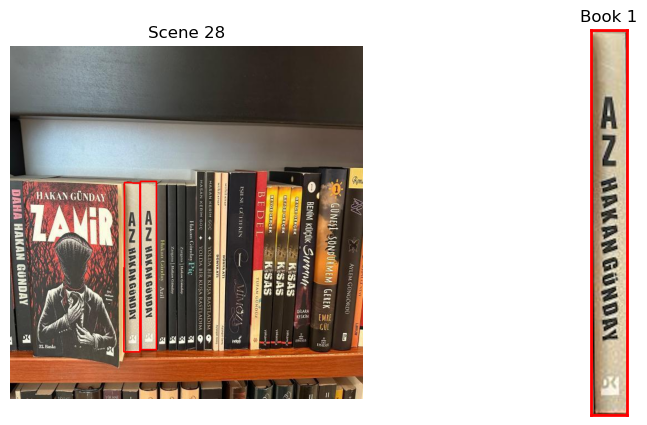

In [25]:
# Number of scenes and models in the dataset
N_SCENES = 28
N_MODELS = 21

# Bounding boxes colors
# red, green, blue
colors = [((255, 0, 0), '#f00'), ((0, 255, 0),'#0f0'), ((0,0,255), '#00f')]

for scene_idx in range(N_SCENES+1):
    # Load scene image
    scene = cv2.imread(
                f"./dataset/scenes/scene_{scene_idx}.jpg", 
                cv2.IMREAD_COLOR_RGB
            )

    # The scene image where bounding boxes are added
    scene_with_box = scene.copy()

    # Model index -> bounding boxes information=(coords, rect color)
    model_to_rectsinfo = {}
    
    # Bounding boxes color index
    color_idx=0
    for model_idx in range(N_MODELS+1):
        # Load model image
        model = cv2.imread(
                    f"./dataset/models/model_{model_idx}.png", 
                    cv2.IMREAD_COLOR_RGB
                )
        
        # Detect instances of model in scene
        # 1. draw bounding boxes on scene_with_box
        # 2. return the bounding boxes coordinates to rects_coords
        rects_coords =  multi_instance_detection(
                            model, 
                            scene, 
                            scene_with_box, 
                            color=colors[color_idx][0]
                        )

        # If any instance was detected in scene
        # 1. add the results to model_to_rectsinfo
        # 2. update color_idx
        if rects_coords:
            model_to_rectsinfo[model_idx] = (rects_coords, colors[color_idx][1])
            color_idx = (color_idx+1)%3

    # If any model was detected in the scene, show the results
    if model_to_rectsinfo:
        print(f"Scene {scene_idx}")

        plt.figure(figsize=(10, 5 * len(model_to_rectsinfo)))
        plt.subplot(len(model_to_rectsinfo), 2, 1)
        plt.title(f"Scene {scene_idx}")
        for i, (model_idx, rects) in enumerate(model_to_rectsinfo.items()):
            rects_coords, rects_colors = rects

            # Scene
            plt.subplot(len(model_to_rectsinfo), 2, 2*i + 1)
            plt.axis('off')
            plt.imshow(scene_with_box)

            # Model
            plt.subplot(len(model_to_rectsinfo), 2, 2*i + 2)
            plt.title(f"Book {model_idx}")
            model_img = cv2.imread(f"./dataset/models/model_{model_idx}.png", cv2.IMREAD_COLOR_RGB)
            ax = plt.gca()  # Get current axes (right subplot)
            for spine in ax.spines.values():
                spine.set_color(rects_colors)
                spine.set_linewidth(2)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(model_img)

            # Print bounding boxes coordinates and areas
            print(f"Book {model_idx} - {len(rects_coords)} instance(s) found:")
            for i, coords in enumerate(rects_coords):
                print("  Instance " + f"{i+1} " + "{" + f"top_left: {coords['top_left']}, top_right: {coords['top_right']}, bottom_left: {coords['bottom_left']}, bottom_right: {coords['bottom_right']}, area: {coords['area']}px" + "}")
            
        plt.show()